In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import string
import os
import glob
from PIL import Image
from time import time
from tensorflow.python import keras

from keras import Input, layers
from keras import optimizers
#from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.optimizer_v2 import adam
from keras_preprocessing import sequence
from keras_preprocessing import image
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout, Bidirectional
#from tensorflow.keras.layers.wrappers import Bidirectional
from keras.layers.merging import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.efficientnet_v2 import EfficientNetV2L
from keras.applications.efficientnet_v2 import preprocess_input
from keras.models import Model
#from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.utils.np_utils import to_categorical

## model for feature extract

In [2]:
import keras as kr
model_EfficientNetV2L = EfficientNetV2L(
    include_top=True,
    weights="imagenet",
    pooling='avg',
    classifier_activation="softmax",
)


In [3]:
model_efficientnet_v2 = Model(model_EfficientNetV2L.input, model_EfficientNetV2L.layers[-2].output)

In [4]:
from keras.models import load_model
caption_model_v1 = load_model('EfficientNetV2L_lstm_model.h5')

In [6]:
max_length = 74
vocab = open('./vocab.txt', 'r').read().strip().split('\n')

ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [7]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(480, 480))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [8]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_efficientnet_v2.predict(image) 
    print(fea_vec.shape)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec


In [9]:
def greedySearch_v1(photo, model):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        #print(sequence)
        sequence = pad_sequences([sequence], maxlen=max_length)
        sequence = np.array(sequence)
        yhat = model.predict([photo,sequence], verbose=0) #here we must pass the encoded image otw error show failed to find data adapter
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final


In [10]:
def beam_search_predictions_v1(image, model, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image, par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [12]:
image_name = os.listdir(r"../testingImage/")
image_path = '../testingImage/'

1/1 [==============================] - 9s 9s/step
(1, 1280)


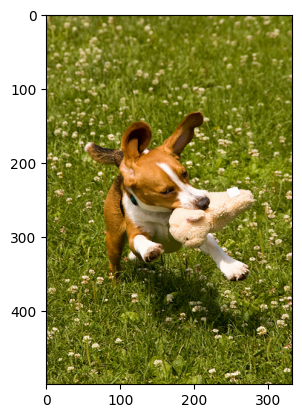

Prediction from model_v1 ::
Greedy Search:======> a dog is running through the grass
Beam Search(K=5):==> a brown dog is running through the grass
1/1 [==============================] - 1s 1s/step
(1, 1280)


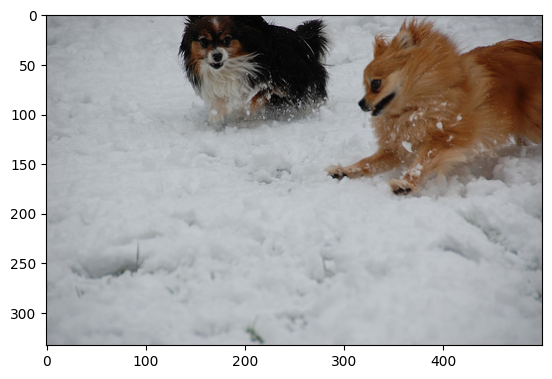

Prediction from model_v1 ::
Greedy Search:======> a dog is running through a field of grass
Beam Search(K=5):==> a brown dog runs through the snow with a tennis ball in its mouth
1/1 [==============================] - 2s 2s/step
(1, 1280)


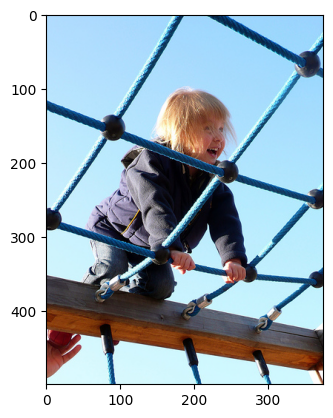

Prediction from model_v1 ::
Greedy Search:======> a young girl is swinging on a swing
Beam Search(K=5):==> a little girl swings on a swing on a playground
1/1 [==============================] - 2s 2s/step
(1, 1280)


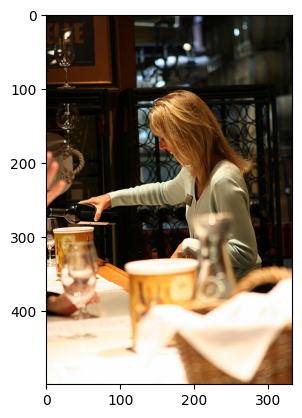

Prediction from model_v1 ::
Greedy Search:======> a man in a white shirt is sitting at a table with a glass of wine
Beam Search(K=5):==> a group of people are sitting at a table drinking wine
1/1 [==============================] - 2s 2s/step
(1, 1280)


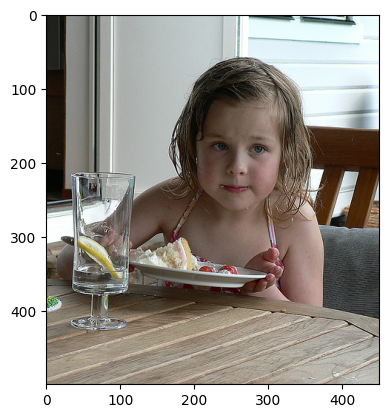

Prediction from model_v1 ::
Greedy Search:======> a young girl in a pink shirt is eating a sandwich
Beam Search(K=5):==> a little girl is eating a slice of cake
1/1 [==============================] - 1s 1s/step
(1, 1280)


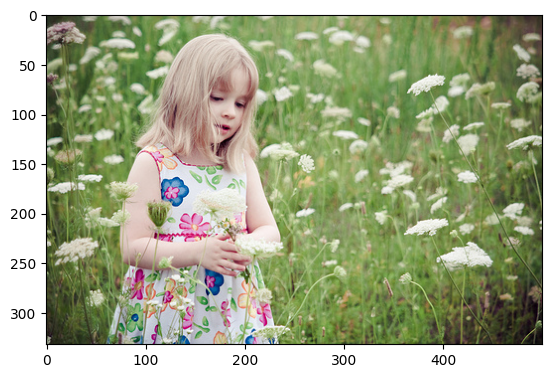

Prediction from model_v1 ::
Greedy Search:======> a little girl in a pink dress is standing in a field
Beam Search(K=5):==> a little girl in a pink dress is holding a teddy bear
1/1 [==============================] - 1s 1s/step
(1, 1280)


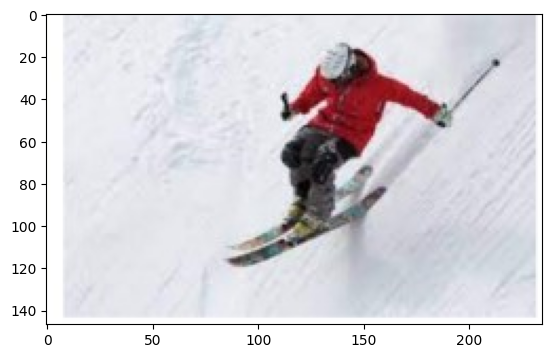

Prediction from model_v1 ::
Greedy Search:======> a skier in a red jacket is skiing down a snowy mountain
Beam Search(K=5):==> a young man skiing down a snow covered mountain


In [13]:
for oneimg in image_name:
    full_img_path = image_path+str(oneimg)
    
    encoded_img1 = encode( full_img_path )
    encoded_img1 = encoded_img1.reshape(1,1280)
    
    x = plt.imread(full_img_path)
    plt.imshow(x)
    plt.show()
    print("Prediction from model_v1 ::")
    print("Greedy Search:======>",greedySearch_v1(encoded_img1,caption_model_v1))
    print("Beam Search(K=5):==>",beam_search_predictions_v1(encoded_img1,caption_model_v1, beam_index = 5))
    